# Analyse exploratoire du jeu de données

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

### 1- Étudier la répartition par race et par type (chat/chien)

Le jeu de données est composé de 7349 lignes.
Chaque ligne a :
- un type : chat ou chien
- une race : 37 races différentes

In [50]:
# Lecture du fichier list.txt
df = pd.read_csv(
    "./oxford-iiit-pet/annotations/list.txt",
    sep=r"\s+",                                         # séparateur = espaces multiples
    comment="#",                                        # ignorer les lignes commençant par #
    header=None,                                        # pas d'en-tête dans les lignes de données
    names=["Image", "CLASS_ID", "SPECIES", "BREED_ID"]  # noms des colonnes
)

# On rajoute deux colonnes pour mieux labelliser les données
df["BREED_NAME"] = df["Image"].str.split("_").str[0]             # Nom de la race
df["SPECIES_NAME"] = df["SPECIES"].map({1: "Cat", 2: "Dog"})    # Chat ou chien

# Et on ajoute du chemin complet vers chaque image. Il faut faire attention car les images ne sont pas dans "annotations" mais dans le dossier "images"
df["Image"] = df["Image"].apply(lambda x: f"{x}.jpg")
path="./oxford-iiit-pet/images/"
print(df.head())


                Image  CLASS_ID  SPECIES  BREED_ID  BREED_NAME SPECIES_NAME
0  Abyssinian_100.jpg         1        1         1  Abyssinian          Cat
1  Abyssinian_101.jpg         1        1         1  Abyssinian          Cat
2  Abyssinian_102.jpg         1        1         1  Abyssinian          Cat
3  Abyssinian_103.jpg         1        1         1  Abyssinian          Cat
4  Abyssinian_104.jpg         1        1         1  Abyssinian          Cat


On peut compter le nombre de chiens et de chats :

SPECIES_NAME
Dog    4978
Cat    2371
Name: count, dtype: int64


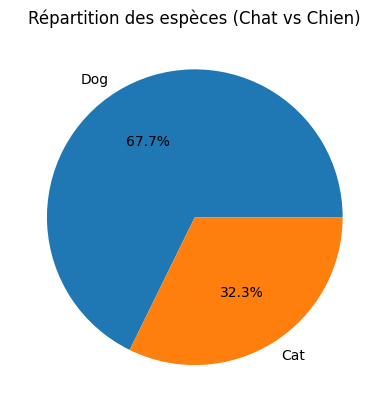

In [51]:
counts = df["SPECIES_NAME"].value_counts()
print(counts)
plt.pie(counts,labels=counts.index,autopct="%1.1f%%")
plt.title("Répartition des espèces (Chat vs Chien)")
plt.show()

On fait la même chose pour les races

BREED_NAME
american         400
english          396
basset           200
yorkshire        200
beagle           200
Birman           200
Bengal           200
chihuahua        200
great            200
german           200
British          200
japanese         200
leonberger       200
Maine            200
havanese         200
pug              200
pomeranian       200
Persian          200
miniature        200
Russian          200
shiba            200
wheaten          200
Sphynx           200
saint            200
Ragdoll          200
samoyed          200
Siamese          199
keeshond         199
scottish         199
boxer            199
Abyssinian       198
newfoundland     196
Egyptian         190
staffordshire    189
Bombay           184
Name: count, dtype: int64


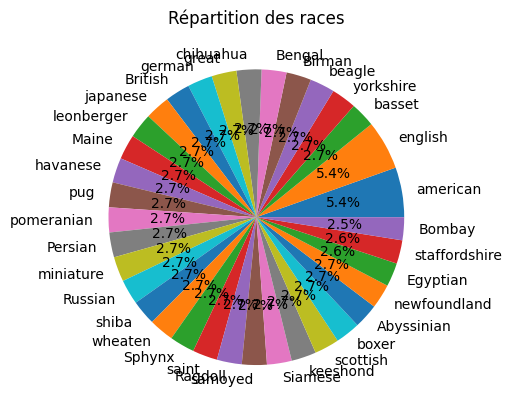

In [52]:
counts = df["BREED_NAME"].value_counts()
print(counts)
plt.pie(counts,labels=counts.index,autopct="%1.1f%%")
plt.title("Répartition des races")
plt.show()

### 2- Vérifier la cohérence et la qualité des masques de segmentation

Les masques de ségmentation se trouvent dans le dossier *oxford-iiit-pet/annotations/trimaps*.
Chaque image du jeu de données possède un masque associé qui délimite les pixels selon trois classes :
- 1 = Foreground (le corps de l'animal)
- 2 = Background (le fond de l'image)
- 3 = Not classified (on sait pas ce que sait)

Pour vérifier la cohérence et la qualité des masques, on va regarder à la main un petit échantillons, en affichant côte à côte les images et le masque associé.

Nombre de masques valides : 7390
indice: 1234 , nom de l'image: Maine_Coon_138


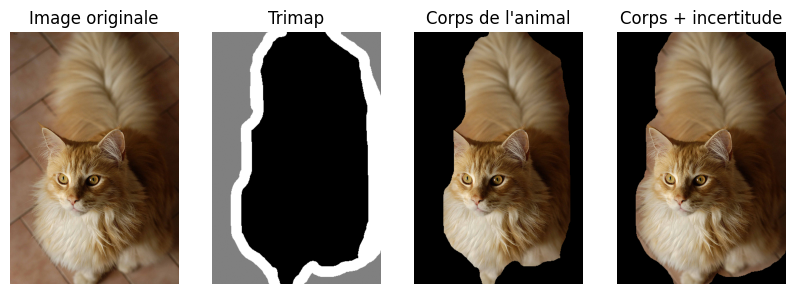

indice: 4321 , nom de l'image: great_pyrenees_28


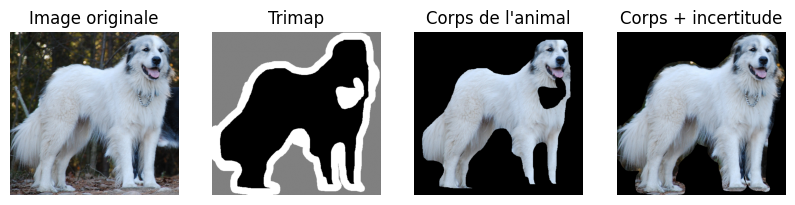

indice: 1000 , nom de l'image: Egyptian_Mau_1


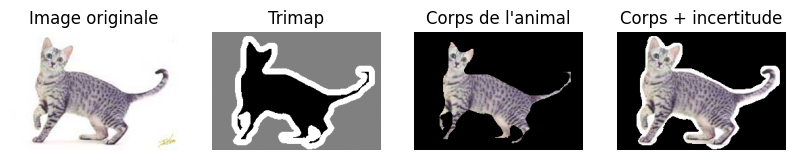

indice: 2000 , nom de l'image: Siamese_100


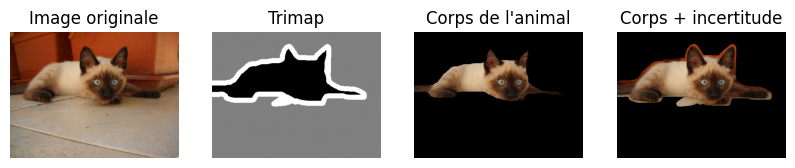

indice: 3000 , nom de l'image: beagle_1


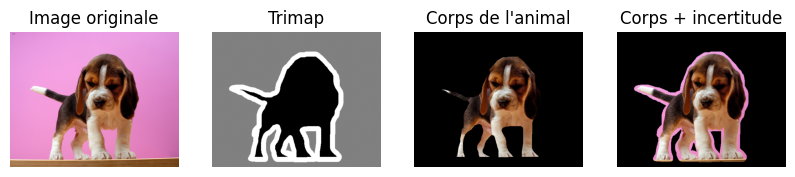

In [53]:

indices = [1234,4321,1000,2000,3000]# <-- Il suffit de changer l'indice pour choisir l'image que l'on veut vérifier (à choisir entre 0 et 7348)
img_dir = "oxford-iiit-pet/images/"
mask_dir = "oxford-iiit-pet/annotations/trimaps/"
masks = [f for f in os.listdir(mask_dir) if f.endswith(".png") and not f.startswith("._")]
print(f"Nombre de masques valides : {len(masks)}")
for indice in indices:
    example = masks[indice]
    name = os.path.splitext(example)[0]
    print("indice:",indice,", nom de l'image:",name)

    #On récupère les paths
    img_path = os.path.join(img_dir, name + ".jpg")
    mask_path = os.path.join(mask_dir, example)

    #On récupère les valeurs des pixels dans des np.array (on utilise la librairie PIL pour faire cela)
    img = np.array(Image.open(img_path))
    mask = np.array(Image.open(mask_path))

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) 
    masked_img_moins= img.copy()
    masked_img_moins[mask != 1] = 0   # on garde seulement les pixels 1, on met tout le reste à 0 (en noir)

    #On visualise les pixels qui composent le corps de l'animal selon le masque (1) et la zone d'incertitude (2)
    masked_img_plus= img.copy()
    masked_img_plus[mask == 2] = 0   # on garde seulement les pixels 1 et 3, on met les pixel 2 à 0 (en noir)

    #On affiche nos 4 images
    plt.figure(figsize=(10,5))
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Trimap")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(masked_img_moins)
    plt.title("Corps de l'animal")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(masked_img_plus)
    plt.title("Corps + incertitude")
    plt.axis("off")

    plt.show()

En parcourant à la main les images, les masques semblent cohérents et de plutot bonne qualité.
Il peut y avoir des confusions lorsque l'animal porte un colier par exemple (indice 4321) mais dans l'ensemble on obtient ce qu'on attend du masque.

### 3- Identifier d’éventuels déséquilibres ou biais visuels

Je ne sais pas quoi dire ici

# Classification Binaire

On cherche à distinguer les chats des chiens à partir de leur photo uniquement.

In [54]:
# Data visualization
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

Le réseau de neurones que l'on va mettre en place par la suite a besoin de prendre en entrée des données de taille fixe. Nous allons donc commencer par controler la taille de nos images.

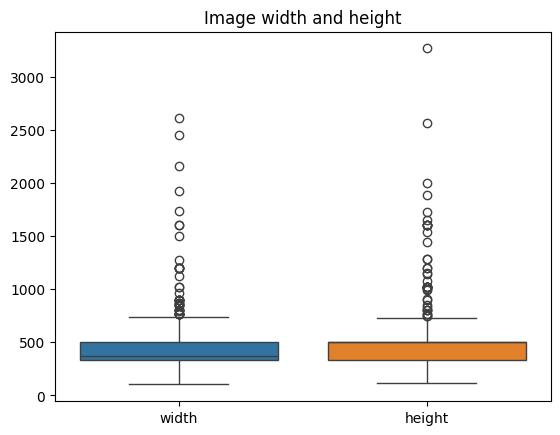

In [55]:
from tensorflow.keras.utils import load_img, img_to_array

img_size = np.zeros((df.shape[0],2))
for i, image in enumerate(df['Image']) :
    img = img_to_array( load_img(path + image) )
    img_size[i,:] = img.shape[:2]

# --- #

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()

On observe que toutes les images n'ont pas les mêmes dimensions. Nous allons donc devoir les redimensionner.  
Pour cela nous allons imposer que toutes les images soient de taille (150 x 150). (On peut choisir une plus grande taille si besoin, mais on s'expose à des couts de calcul plus élevés).
On a maintenant un choix. Ou bien on redimensionne toutes les images dès maintenant puis on les sépare en données de test, d'entrainement et de validation. Ou bien on sépare d'abord puis on les redimensionne.
Afin de suivre ce qui a été fait en TP, on choisit la deuxième approche.

- On sépare en données d'entrainement, de validation et de test :

In [56]:
from sklearn.model_selection import train_test_split

# On part du DataFrame complet : df qui a comme colonnes : mage, CLASS_ID, SPECIES, BREED_ID, BREED_NAME, SPECIES_NAME

# On crée d’abord une version simplifiée pour la séparation
data = df[["Image", "SPECIES_NAME"]].copy()


N_train = 5200          # environ 70% de l'ensemble des données
N_Validation = 1000  
temp_df, train_df = train_test_split(data, test_size=N_train, stratify=data["SPECIES_NAME"])               # On prend 5000
test_df, validation_df = train_test_split(temp_df, test_size=N_Validation, stratify=temp_df["SPECIES_NAME"])    # On prend 1000  dans ce qu'il reste N_test = N_total - (N_train+N_validation)

print("Train set :", train_df.shape)
print("Validation set :", validation_df.shape)
print("Test set :", test_df.shape)
print("\n----Répartition des catégories----\n")
print("Train :", train_df["SPECIES_NAME"].value_counts())
print("\nValidation :", validation_df["SPECIES_NAME"].value_counts())
print("\nTest :", test_df["SPECIES_NAME"].value_counts())

Train set : (5200, 2)
Validation set : (1000, 2)
Test set : (1149, 2)

----Répartition des catégories----

Train : SPECIES_NAME
Dog    3522
Cat    1678
Name: count, dtype: int64

Validation : SPECIES_NAME
Dog    678
Cat    322
Name: count, dtype: int64

Test : SPECIES_NAME
Dog    778
Cat    371
Name: count, dtype: int64


- On redimensionne

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 20  # divider of N_train and N_validation (20 est bien un diviseur de 5200 et 1000)
img_width = 150
img_height = 150

path_image="Projet-1-Segmentation"
# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1149 validated image filenames belonging to 2 classes.


On peut maintenant mettre en place notre réseau de neurones. AJOUTER DES EXPLICATIONS ICI

In [58]:
def cnn_simple():
    cnn = Sequential()
    cnn.add(Input(shape=(img_width,img_height,3)))
    cnn.add(Conv2D(32, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Conv2D(64, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Conv2D(96, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))
    cnn.add(Flatten())
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dropout(0.5))
    cnn.add(Dense(1, activation='sigmoid'))
    cnn.summary()
    return cnn

cnn_naif=cnn_simple()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 27744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │     1,775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,850,529 (7.06 MB)

 Trainable params: 1,850,529 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrainement du modèle
Nous faisons face à un problème de classification, on choisit donc d'utiliser comme fonction de coût la : $\texttt{binary\_crossentropy}$

In [67]:
import time

epochs = 10

def Entrainement(cnn,epochs,train_generator):
    
    cnn.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=3e-4),
        metrics = ['accuracy'])

    t_learning_cnn = time.time()
    
    cnn_history = cnn.fit(
        train_generator,
        validation_data = validation_generator,
        epochs = epochs
    )
    
    t_learning_cnn = time.time() - t_learning_cnn
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn))
    
    return t_learning_cnn, cnn_history, t_learning_cnn

In [ ]:
t_learning_cnn_naif, cnn_naif_history, t_learning_cnn_naif = Entrainement(cnn_naif,epochs,train_generator)

Epoch 1/10


/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


260/260 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.6715 - loss: 0.6115 - val_accuracy: 0.6770 - val_loss: 0.5599
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.7146 - loss: 0.5458 - val_accuracy: 0.7350 - val_loss: 0.5089
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.7502 - loss: 0.5166 - val_accuracy: 0.7540 - val_loss: 0.4886
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.7746 - loss: 0.4636 - val_accuracy: 0.8020 - val_loss: 0.4480
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.8044 - loss: 0.4280 - val_accuracy: 0.7640 - val_loss: 0.4636
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step - accuracy: 0.8256 - loss: 0.3927 - val_accuracy: 0.7800 - val_loss: 0.4532
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8383 - loss: 0.3583 - val_accuracy: 0.7780 - val_loss: 0.4516
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.8571 - loss: 0.3242 - val_accurac

Analyse des résultats

In [61]:
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.9346 - loss: 0.1697
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8050 - loss: 0.4866
Train accuracy: 0.9346153736114502
Validation accuracy: 0.8050000071525574
Time Prediction: 13.90 seconds


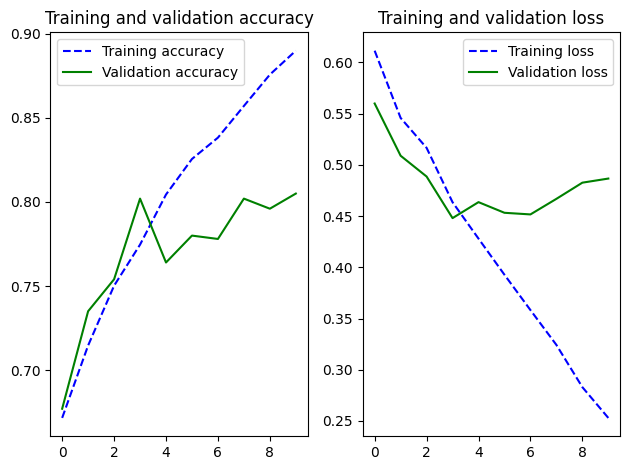

In [62]:
def Analyse_resultats(cnn,cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(validation_generator, verbose=1)

    t_prediction_cnn = time.time() - t_prediction_cnn

    print('Train accuracy:', score_cnn_train[1])
    print('Validation accuracy:', score_cnn_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction_cnn)

    plot_training_analysis(cnn_history)
    return t_prediction_cnn

t_prediction_cnn_naif = Analyse_resultats(cnn_naif,cnn_naif_history)

On a des résultats corrects mais on observe un cas clair de sur-apprentissage. Le modèle est très performant sur les données d'apprentissage, mais il a du mal à généraliser.  
On va essayer de mettre en place une nouvelle approche qui en tient compte.
  
Une solution pour contrer le sur-apprentissage (ou overfitting) est l'augmentation de données. Cela consiste à prendre nos images de départ et leur appliquer des transformations (rotation, décalage, zoom, etc)

In [63]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path,
    x_col ='Image',
    y_col ='SPECIES_NAME',
    target_size=(img_width,img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

Found 5200 validated image filenames belonging to 2 classes.


In [68]:
# On initialise un nouveau réseau (identique au dernier)
cnn_data_augmented = cnn_simple()

# on va l'entrainer avec les données augmentées cette fois
cnn_data_augmented.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

epochs = 10

t_learning_cnn_data_augmented, cnn_data_augmented_history, t_learning_cnn_data_augmented = Entrainement(cnn_data_augmented,epochs,train_generator_augmented)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 27744)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     1,775,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,850,529 (7.06 MB)

 Trainable params: 1,850,529 (7.06 MB)

 Non-trainable params: 0 (0.00 B)

/home/davodeau/.conda/envs/HDDLtensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 32s 115ms/step - accuracy: 0.6756 - loss: 0.6159 - val_accuracy: 0.6780 - val_loss: 0.5968
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 30s 115ms/step - accuracy: 0.6788 - loss: 0.5961 - val_accuracy: 0.6820 - val_loss: 0.5618
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.6869 - loss: 0.5716 - val_accuracy: 0.6870 - val_loss: 0.5508
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 107ms/step - accuracy: 0.6863 - loss: 0.5693 - val_accuracy: 0.6930 - val_loss: 0.5151
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - accuracy: 0.7029 - loss: 0.5592 - val_accuracy: 0.7130 - val_loss: 0.5126
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.7167 - loss: 0.5532 - val_accuracy: 0.7190 - val_loss: 0.5047
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - accuracy: 0.7244 - loss: 0.5424 - val_accuracy: 0.7290 - val_loss: 0.5007
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.7260 - loss: 0

260/260 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.7433 - loss: 0.5378
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.7410 - loss: 0.5502
Train accuracy: 0.7432692050933838
Validation accuracy: 0.7409999966621399
Time Prediction: 16.14 seconds


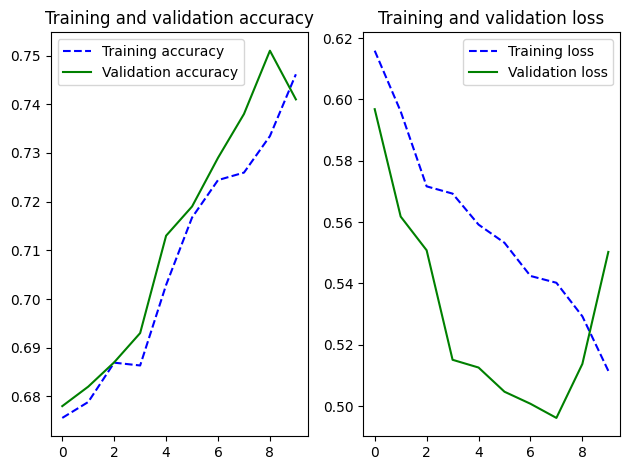

In [69]:
t_prediction_cnn_data_augmented = Analyse_resultats(cnn_data_augmented,cnn_data_augmented_history)

C'est nettement mieux (bon je ne sais pas pourquoi sur la fin ca fait un truc bizarre par contre). Par contre le modèle met beaucoup plus de temps à s'entrainer. On obtient des résultats corrects, mais si on veut faire mieux, il faudrait beaucoup plus de données à notre disposition, ainsi que beaucoup plus de temps.  

La dernière solution pour avoir une meilleure précision est d'utiliser le **Transfer Learning**. On va s'aider d'un réseau pré-entrainé (ici VGG16) et on va y accroché notre propre *MLP classifier*.
On peut aussi combiner cette approche avec l'augmentation de données. Nous avons vu dans le TP que c'est ce qui donne les meilleurs résultats, nous allons donc directement mettre en place cela. 

In [76]:
from tensorflow.keras.applications import VGG16 #on importe VGG16

#Contient la base de VGG
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)
#conv_base.summary()

In [78]:
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False # On ne veut surtout pas toucher aux paramètres de VGG
vgg_combined.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 2,097,665 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [79]:
t_learning_vgg_combined_augmented, vgg_combined_history, t_learning_vgg_combined = Entrainement(vgg_combined,epochs,train_generator_augmented)

Epoch 1/10


2025-11-10 14:54:00.798389: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_604', 52 bytes spill stores, 52 bytes spill loads

2025-11-10 14:54:00.815532: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_604', 8 bytes spill stores, 8 bytes spill loads



260/260 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - accuracy: 0.8004 - loss: 0.4187 - val_accuracy: 0.8890 - val_loss: 0.2695
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.8433 - loss: 0.3518 - val_accuracy: 0.8780 - val_loss: 0.2713
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 28s 108ms/step - accuracy: 0.8494 - loss: 0.3317 - val_accuracy: 0.8970 - val_loss: 0.2590
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.8521 - loss: 0.3132 - val_accuracy: 0.9120 - val_loss: 0.2319
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.8654 - loss: 0.3069 - val_accuracy: 0.9120 - val_loss: 0.2340
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.8687 - loss: 0.2988 - val_accuracy: 0.9100 - val_loss: 0.2230
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.8652 - loss: 0.3059 - val_accuracy: 0.9220 - val_loss: 0.2095
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.8719 - loss: 0.2873 - val

260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - accuracy: 0.9275 - loss: 0.1752
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9190 - loss: 0.2179
Train accuracy: 0.9275000095367432
Validation accuracy: 0.9190000295639038
Time Prediction: 16.92 seconds


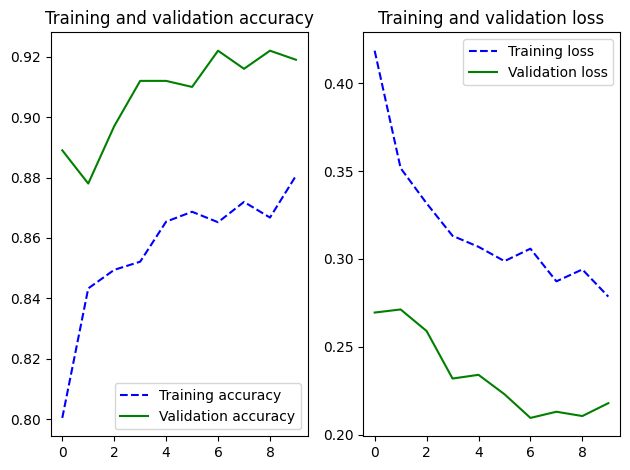

In [80]:
t_prediction_vgg_combined_augmented = Analyse_resultats(vgg_combined,vgg_combined_history)